(sec-tutorial-schedulegettable)=

# Tutorial: ScheduleGettable

```{seealso}
The complete source code of this tutorial can be found in

{nb-download}`ScheduleGettable.ipynb`
```

This tutorial covers the {class}`~quantify_scheduler.gettables.ScheduleGettable` in-depth. If you're looking for more information on how to set up an experiment in general, please see {ref}`sec-tutorial-experiment`.

The {class}`~quantify_scheduler.gettables.ScheduleGettable` forms the top-level interface to {mod}`quantify_scheduler`. Under the hood, it uses `quantify-scheduler` modules to compile {ref}`Schedules <sec-user-guide-creating-a-schedule>`, run them on your hardware and retrieve measurement data from the hardware. As the {class}`~quantify_scheduler.gettables.ScheduleGettable` uses functions that return {class}`~quantify_scheduler.schedules.schedule.Schedule`s, you can dynamically set function parameters during experiments.

For those familiar with [quantify-core](https://quantify-os.org/docs/quantify-core), the interface of the {class}`~quantify_scheduler.gettables.ScheduleGettable` is also designed to be used as a [gettable](https://quantify-os.org/docs/quantify-core/dev/user/concepts.html#settables-and-gettables) for [MeasurementControl](https://quantify-os.org/docs/quantify-core/dev/user/concepts.html#measurement-control). This is convenient for large, possibly multi-dimensional measurement loops, as is demonstrated in {ref}`2D (and ND) measurement loops`.

Two things are always required when using a {class}`~quantify_scheduler.gettables.ScheduleGettable`: a {ref}`QuantumDevice <sec-user-guide-quantum-device-elements>` and a function that returns a {class}`~quantify_scheduler.schedules.schedule.Schedule`. We will set these up in a few example scenarios below and show how to use the {class}`~quantify_scheduler.gettables.ScheduleGettable`. More commonly used schedule functions are also included in `quantify-scheduler` out of the box. You can find them in {mod}`~.quantify_scheduler.schedules.spectroscopy_schedules`, {mod}`~.quantify_scheduler.schedules.timedomain_schedules` and {mod}`~.quantify_scheduler.schedules.trace_schedules`.

(sec-schedulegettable-1dsweep-usage)=

## 1D iterative measurement loop


```{admonition} Setup and hardware configuration
The device setup and hardware configuration for this tutorial can be viewed in the collapsed code cells. In places where you would communicate with actual hardware, dummy objects have been used. If you want to learn more about how to set up the {class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice` and hardware configuration, please see our other tutorials, in particular {ref}`sec-tutorial-experiment` and {ref}`sec-tutorial-compiling`.
```

In [1]:
from qblox_instruments import Cluster, ClusterType
from quantify_core.data import handling as dh

from quantify_scheduler import BasicTransmonElement, InstrumentCoordinator, QuantumDevice
from quantify_scheduler.qblox import ClusterComponent, start_dummy_cluster_armed_sequencers

# First, don't forget to set the data directory!
dh.set_datadir()  # change me!

# We define a single transmon qubit as an element (BasicTransmonElement) of the
# QuantumDevice, and populate the parameters with some reasonable values.

# Device parameters
ACQ_DELAY = 100e-9
FREQ_01 = 4e9
READOUT_AMP = 0.1
READOUT_FREQ = 4.3e9
PI_PULSE_AMP = 0.15
LO_FREQ_QUBIT = 3.9e9
LO_FREQ_READOUT = 4.5e9

single_qubit_device = QuantumDevice("single_qubit_device")

q0 = BasicTransmonElement("q0")
single_qubit_device.add_element(q0)

# Assign device parameters to transmon element
q0.measure.pulse_amp(READOUT_AMP)
q0.clock_freqs.readout(READOUT_FREQ)
q0.clock_freqs.f01(FREQ_01)
q0.measure.acq_delay(ACQ_DELAY)
q0.rxy.amp180(PI_PULSE_AMP)

# For this example, we will set up a Qblox cluster hardware setup with two modules: a
# QRM-RF and a QCM-RF.

# Note: if you are connecting to an actual cluster, you would provide the
# 'identifier' argument (the ip address, device name or serial number) instead
# of the 'dummy_cfg' argument.
cluster = Cluster(
    "cluster",
    dummy_cfg={
        1: ClusterType.CLUSTER_QRM_RF,
        2: ClusterType.CLUSTER_QCM_RF,
    },
)

ic_cluster = ClusterComponent(cluster)

# Temporarily fixing dummy cluster's deficiency.
cluster.start_sequencer = lambda : start_dummy_cluster_armed_sequencers(ic_cluster)

# We create an InstrumentCoordinator to control the cluster and add it to the
# QuantumDevice.

instrument_coordinator = InstrumentCoordinator("instrument_coordinator")
instrument_coordinator.add_component(ic_cluster)

single_qubit_device.instr_instrument_coordinator(instrument_coordinator.name)

# A basic hardware configuration will be used for the two cluster modules.

hardware_cfg = {
    "version": "0.2",
    "config_type": "quantify_scheduler.backends.qblox_backend.QbloxHardwareCompilationConfig",
    "hardware_description": {
        f"{cluster.name}": {
            "instrument_type": "Cluster",
            "modules": {
                "1": {
                    "instrument_type": "QRM_RF"
                },
                "2": {
                    "instrument_type": "QCM_RF"
                }
            },
            "ref": "internal"
        }
    },
    "hardware_options": {
        "modulation_frequencies": {
            "q0:res-q0.ro": {
                "lo_freq": LO_FREQ_READOUT
            },
            "q0:mw-q0.01": {
                "lo_freq": LO_FREQ_QUBIT
            }
        }
    },
    "connectivity": {
        "graph": [
            [f"{cluster.name}.module1.complex_output_0", "q0:res"],
            [f"{cluster.name}.module1.complex_input_0", "q0:res"],
            [f"{cluster.name}.module2.complex_output_0", "q0:mw"]
        ]
    }
}


# This hardware configuration should also be added to the quantum device.
single_qubit_device.hardware_config(hardware_cfg)

Data will be saved in:
/root/quantify-data


For this experiment, we have set up a basic {class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice` called `single_qubit_device`, representing a single transmon qubit.

We'll now define the schedule function. A valid schedule function must contain a `repetitions` (integer) parameter (see {ref}`Repetitions`), and can contain any number of additional parameters. It must return a {class}`~quantify_scheduler.schedules.schedule.Schedule` object.

The schedule function can be parameterized to loop over different values. The parameters can be scalars or arrays. For example, the schedule function defined below takes an array of values for the parameter `times`. This is called a _batched_ measurement, as will be explained further in this tutorial.

In [2]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations import Measure, Reset, X

def t1_sched(times, repetitions=1):
    schedule = Schedule("T1", repetitions)
    for i, tau in enumerate(times):
        schedule.add(Reset("q0"), label=f"Reset {i}")
        schedule.add(X("q0"), label=f"pi {i}")
        # Measure tau seconds after the start of the X gate
        schedule.add(
            Measure("q0", acq_index=i),
            ref_pt="start",
            rel_time=tau,
            label=f"Measurement {i}",
        )
    return schedule

Now, let's create the {class}`~quantify_scheduler.gettables.ScheduleGettable`. The {class}`~quantify_scheduler.gettables.ScheduleGettable` provides a convenient way to compile and execute schedules in just a few lines of code. The parameters can be set directly, with arrays and scalars, or through QCoDeS parameters, as shown below.

In [3]:
import numpy as np

from qcodes.instrument.parameter import ManualParameter

from quantify_scheduler import ScheduleGettable

# The points we want to measure.
times = np.linspace(start=1.6e-7, stop=4.976e-5, num=125)

# As QCoDeS parameter:
time = ManualParameter("sample", label="Sample time", unit="s")
# Set the parameter. This can be done even after defining the gettable!
time(times)

# Or as array:
time = times

# Configure the gettable
gettable = ScheduleGettable(
    quantum_device=single_qubit_device,
    schedule_function=t1_sched,
    schedule_kwargs={"times": time},
    batched=True
)

Note that `batched=True` here. This means we are doing a _batched_ measurement, which simply means that we tell the {class}`~quantify_scheduler.gettables.ScheduleGettable` to expect an array of values in the acquisition result. In this case, our schedule function creates one schedule for an array of times, and it includes an acquisition (the {class}`~quantify_scheduler.operations.gate_library.Measure` operation) for each point.

In [4]:
import xarray

from quantify_scheduler.waveforms import soft_square

from qblox_instruments import DummyScopeAcquisitionData, DummyBinnedAcquisitionData


soft_sq_samples = round(q0.measure.integration_time() * 1e9)
soft_sq_times = np.arange(soft_sq_samples)
soft_sq = soft_square(t=soft_sq_times, amp=0.5)
scope_data_real = np.zeros(16384)  # Scope trace acquires 16384 points
scope_data_real[:soft_sq_samples] = soft_sq
scope_data_real += np.random.randn(16384) / 500  # add some "noise"

# Create dummy scope data with the soft square pulse on the I path and noise on
# the Q path
scope_data = list(zip(scope_data_real, np.random.randn(16384) / 500))

dummy_scope_acquisition_data = DummyScopeAcquisitionData(
        data=scope_data, out_of_range=(False, False), avg_cnt=(0, 0)
    )

ic_cluster.instrument.set_dummy_scope_acquisition_data(
    slot_idx=1, sequencer=None, data=dummy_scope_acquisition_data
)


# Dataset with T1 experiment data
example_dataset = xarray.open_dataset("../examples/dataset.hdf5")

def get_dummy_binned_acquisition_data(real: float, imag: float):
    return DummyBinnedAcquisitionData(data=(real, imag), thres=0, avg_cnt=0)

ic_cluster.instrument.set_dummy_binned_acquisition_data(
    slot_idx=1,
    sequencer=0,
    acq_index_name="0",
    data=[
        get_dummy_binned_acquisition_data(float(re) * 1024, float(im) * 1024)
        for re, im in zip(example_dataset["y0"], example_dataset["y1"])
    ],
)

Let's now run the experiment and retrieve the acquisitions using the {meth}`~quantify_scheduler.gettables.ScheduleGettable.get` method.

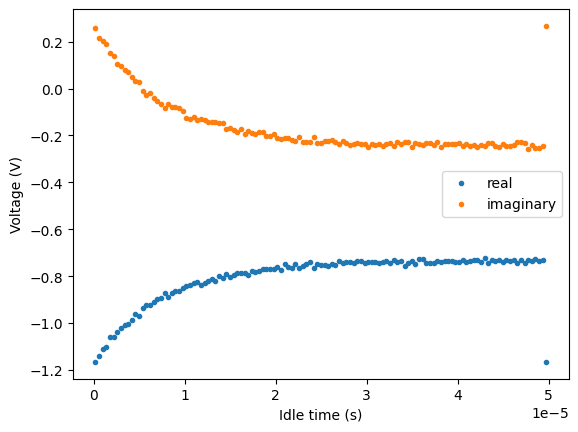

In [5]:
import matplotlib.pyplot as plt


data = gettable.get()

plt.plot(times, data[0], '.', label="real")
plt.plot(times, data[1], '.', label="imaginary")
plt.legend()
plt.xlabel("Idle time (s)")
plt.ylabel("Voltage (V)")
plt.show()

Note that the data used here is the same as in {ref}`sec-tutorial-experiment`. The example dataset can be downloaded {download}`here <../examples/dataset.hdf5>`.

As we defined 125 points in our `times` array which were measured in 125 different `acq_index`es, the acquisition result also contains 125 _I_ values (in `data[0][:]`) and 125 _Q_ values (in `data[1][:]`). The general format of the data returned by the {class}`~quantify_scheduler.gettables.ScheduleGettable` is also explained in the {ref}`user guide <sec-user-guide-acquisition-data-schedulegettable>`.

## Trace measurement

The previous experiment's acquisition results had one data point for each acquisition in the schedule. For a trace measurement, the data format is slightly different. To illustrate this, let us set up an experiment with a trace measurement.

In [6]:
from quantify_scheduler.operations import IdlePulse, SoftSquarePulse


def trace_schedule(pulse_amp, acq_delay, port="q0:res", clock="q0.ro", repetitions=1):
    schedule = Schedule("Trace a pulse", repetitions=repetitions)

    schedule.add(
        SoftSquarePulse(
            duration=q0.measure.integration_time(),
            amp=pulse_amp,
            port=port,
            clock=clock,
        ),
        label="trace_pulse",
    )

    # Add acq_delay to compensate for time-of-flight of the pulse
    schedule.add(
        Measure(q0.name, acq_protocol="Trace"),
        ref_pt="start",
        rel_time=acq_delay,
        label="acquisition"
    )

    return schedule

Again, we define the gettable and run the experiment.

/usr/local/lib/python3.9/site-packages/quantify_scheduler/backends/qblox/compiler_abc.py:668: RuntimeWarning: Operation is interrupting previous Pulse because it starts before the previous ends, offending operation: Pulse "SquarePulse" (t0=1.0000000000000001e-07, duration=3e-07)
  warnings.warn(


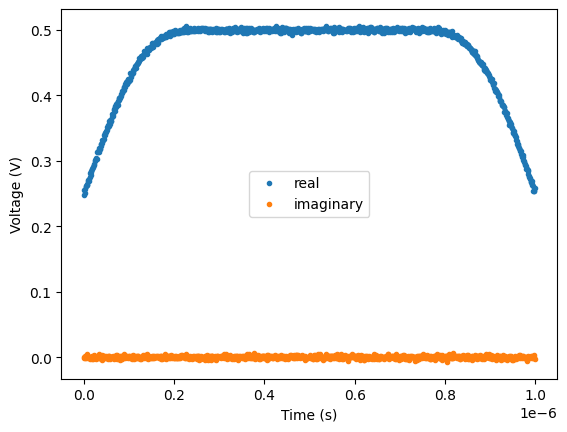

In [7]:
gettable = ScheduleGettable(
    quantum_device=single_qubit_device,
    schedule_function=trace_schedule,
    schedule_kwargs={
        "pulse_amp": 0.5,
        "acq_delay": 100e-9,
        },
    batched=True,
)

data = gettable.get()

plt.plot(np.arange(1000)/1e9, data[0], '.', label="real")
plt.plot(np.arange(1000)/1e9, data[1], '.', label="imaginary")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.show()

This time, there is only one acquisition operation in the schedule. The measurement result contains two arrays: one for the _I_ values (`data[0][:]`), and one for the _Q_ values (`data[1][:]`) of the acquired trace.

## MeasurementControl

Iterating through different parameters can be done with some help from `quantify-core` as well, through the {class}`~quantify_core.measurement.control.MeasurementControl` class. The {class}`~quantify_core.measurement.control.MeasurementControl` uses settables (parameters to vary in an experiment) and gettables (in this case, our {class}`~quantify_scheduler.gettables.ScheduleGettable`). The settable must be a class that implements `set()`, such as a QCoDeS {class}`~qcodes.parameters.ManualParameter`.

In this example, the settable is the `time` object, and the setpoints are a numpy array of values (`times`). These are added to the {class}`~quantify_core.measurement.control.MeasurementControl` as shown, together with the {class}`~quantify_scheduler.gettables.ScheduleGettable`. The {class}`~quantify_core.measurement.control.MeasurementControl` object will be in charge of setting the setpoints, and retrieving the measurement results through the gettable.

In [8]:
from quantify_core.measurement.control import MeasurementControl


measurement_control = MeasurementControl("measurement_control")

# Configure the settable
time = ManualParameter("sample", label="Sample time", unit="s")
time.batched = True

times = np.linspace(start=1.6e-7, stop=4.976e-5, num=125)

# Configure the gettable
gettable = ScheduleGettable(
    quantum_device=single_qubit_device,
    schedule_function=t1_sched,
    schedule_kwargs={"times": time},
    batched=True
)

# Configure MeasurementControl
measurement_control.settables(time)
measurement_control.setpoints(times)
measurement_control.gettables(gettable)

The experiment is set to run fully in _batched_ mode. When using {class}`~quantify_core.measurement.control.MeasurementControl`, settables and gettables can be either batched (an array of points is set for each measurement iteration) or iterative (only one point is set per iteration). Combinations of batched and iterative settables are possible, as explained in detail in the [quantify-core documentation](https://quantify-os.org/docs/quantify-core/dev/user/concepts.html#mixing-iterative-and-batched-settables).

Settables and gettables are batched if they have the attribute `batched=True`. In {class}`~quantify_scheduler.gettables.ScheduleGettable`, this can be controlled through the `batched` argument when creating the class. For other classes, the attribute can be added dynamically if needed, as shown above for the `time` parameter.

With both the gettable and the settable having `batched=True`, the {class}`~quantify_core.measurement.control.MeasurementControl` knows that it should set the entire `times` array as the settable's value (instead of repeating the experiment for each value in the array). All data points are measured without interruption and all measurement results are returned in one go. Now, let's run the experiment and retrieve the data.

In [9]:
dataset = measurement_control.run()

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 --- (None) --- 
Batched settable(s):
	 sample 
Batch size limit: 125



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

The {class}`~quantify_core.measurement.control.MeasurementControl` class processes the data returned by the {class}`~quantify_scheduler.gettables.ScheduleGettable`, and turns it into a {class}`~xarray.Dataset`. More information on the format of this dataset can be found in the [quantify-core documentation](https://quantify-os.org/docs/quantify-core/dev/user/concepts.html#dataset).

In [10]:
dataset

<xarray.Dataset> Size: 3kB
Dimensions:  (dim_0: 125)
Coordinates:
    x0       (dim_0) float64 1kB 1.6e-07 5.6e-07 9.6e-07 ... 4.936e-05 4.976e-05
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 1kB -1.166 -1.141 -1.109 ... -0.737 -0.7305 -1.164
    y1       (dim_0) float64 1kB 0.2569 0.2138 0.2035 ... -0.2533 -0.247 0.2671
Attributes:
    tuid:                             20250117-153831-528-134b3e
    name:                             
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

The dataset coordinates and data variables are named as generic `x` and `y` parameters. You can click on the 'Show/Hide attributes' button next to the coordinates and variables to see what they refer to.

(sec-tutorial-schedulegettable-repetitions)=
## Repetitions

Repetition defines how many times the defined schedule will run on the hardware. Running the schedule multiple times can be useful for example if the user would like to reduce errors of acquisitions by averaging the result of multiple measurements.

There are multiple ways the repetitions can be set. They are not completely independent of each other, and which setting will be taken into account depends on how you create and use the schedule.

1. {class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice`: via `cfg_sched_repetitions` (by default it is `1024`),
2. schedule function: via the `repetitions` function argument,
3. {class}`~quantify_scheduler.schedules.schedule.Schedule` object: via the `repetitions` function argument of its constructor, or via its `repetitions` attribute directly,
4. ({class}`~quantify_scheduler.gettables.ScheduleGettable`: currently, it is not possible to supply `repetitions` via `schedule_kwargs`).

Ultimately, the {class}`~quantify_scheduler.schedules.schedule.Schedule` object is what governs the repetitions, via its `repetitions` attribute.

When using a schedule function, the `repetitions` function argument sets the repetitions, provided that the schedule function passes it to the `Schedule` object. This is true for the pre-defined schedules, see {mod}`!quantify_scheduler.schedules`.

However, if the experiment is run using `ScheduleGettable`, this `repetitions` function argument is set to `QuantumDevice.cfg_sched_repetitions`. Hence, typically, the schedule will run `QuantumDevice.cfg_sched_repetitions` times.

### Possible mistake: ignoring `repetitions` argument

Keep in mind that the schedule function should pass the `repetitions` argument to the `Schedule` initializer, otherwise both `QuantumDevice.cfg_sched_repetitions` and the `repetitions` argument of the schedule function will be ignored. For example, in the following setup, the `repetitions` will always be `1` (default for the `Schedule` object), even if `cfg_sched_repetitions` is set to `2`.

In [11]:
from quantify_scheduler import QuantumDevice, ScheduleGettable

def schedule_function(q0: str, repetitions: int):
    schedule = Schedule("Example schedule")
    schedule.add(Measure(q0, acq_index=0))
    return schedule

quantum_device = QuantumDevice(name="quantum_sample")
quantum_device.cfg_sched_repetitions(2)

schedule_gettable = ScheduleGettable(
    quantum_device=quantum_device,
    schedule_function=schedule_function,
    schedule_kwargs={"q0": "q0"},
)

### Possible mistake: ignoring `cfg_sched_repetitions` default value

Also note, that the default value of the `repetitions` argument of the schedule function will be ignored if `ScheduleGettable` is used, and it will be set to `QuantumDevice.cfg_sched_repetitions`. For example, in the following setup, `repetitions` will be `1024` (default for `QuantumDevice`), even if the default argument for `repetitions` is `2`.

In [12]:
quantum_device.close()

In [13]:
from quantify_scheduler import QuantumDevice, ScheduleGettable

def schedule_function(q0: str, repetitions: int = 2):
    schedule = Schedule("Example schedule", repetitions=repetitions)
    schedule.add(Measure(q0, acq_index=0))
    return schedule

quantum_device = QuantumDevice(name="quantum_sample")

schedule_gettable = ScheduleGettable(
    quantum_device=quantum_device,
    schedule_function=schedule_function,
    schedule_kwargs={"q0": "q0"},
)

(sec-schedulegettable-2dsweep-usage)=

## 2D (and ND) measurement loops

In [14]:
from qblox_instruments import Cluster, ClusterType, DummyBinnedAcquisitionData

from quantify_scheduler import BasicTransmonElement, InstrumentCoordinator, QuantumDevice
from quantify_scheduler.qblox import ClusterComponent


single_qubit_device.close_all()

# Device parameters
Q0_ACQ_DELAY = 100e-9
Q0_FREQ_01 = 4e9
Q0_READOUT_AMP = 0.1
Q0_READOUT_FREQ = 4.3e9
Q0_PI_PULSE_AMP = 0.15
Q0_LO_FREQ_QUBIT = 3.9e9
Q0_LO_FREQ_READOUT = 4.5e9

Q1_ACQ_DELAY = 120e-9
Q1_FREQ_01 = 4.1e9
Q1_READOUT_AMP = 0.1
Q1_READOUT_FREQ = 3.8e9
Q1_PI_PULSE_AMP = 0.15
Q1_LO_FREQ_QUBIT = 4.1e9
Q1_LO_FREQ_READOUT = 3.8e9

two_qubit_device = QuantumDevice("two_qubit_device")

q0 = BasicTransmonElement("q0")
q0.measure.acq_channel(0)
q0.measure.pulse_amp(Q0_READOUT_AMP)
q0.clock_freqs.readout(Q0_READOUT_FREQ)
q0.clock_freqs.f01(Q0_FREQ_01)
q0.measure.acq_delay(Q0_ACQ_DELAY)
q0.rxy.amp180(Q0_PI_PULSE_AMP)

q1 = BasicTransmonElement("q1")
q1.measure.acq_channel(1)  # Note that we're specifying that measurements on q1 should use a different measurement channel
q1.measure.pulse_amp(Q1_READOUT_AMP)
q1.clock_freqs.readout(Q1_READOUT_FREQ)
q1.clock_freqs.f01(Q1_FREQ_01)
q1.measure.acq_delay(Q1_ACQ_DELAY)
q1.rxy.amp180(Q1_PI_PULSE_AMP)

two_qubit_device.add_element(q0)
two_qubit_device.add_element(q1)

# We will need to adjust the hardware configuration.

# Note: if you are connecting to an actual cluster, you would provide the
# 'identifier' argument (the ip address, device name or serial number) instead
# of the 'dummy_cfg' argument.
cluster = Cluster(
    "cluster",
    dummy_cfg={
        1: ClusterType.CLUSTER_QRM_RF,
        2: ClusterType.CLUSTER_QCM_RF,
        3: ClusterType.CLUSTER_QRM_RF,
        4: ClusterType.CLUSTER_QCM_RF,
    },
)

ic_cluster = ClusterComponent(cluster)

# Temporarily fixing dummy cluster's deficiency.
cluster.start_sequencer = lambda : start_dummy_cluster_armed_sequencers(ic_cluster)

instrument_coordinator = InstrumentCoordinator("instrument_coordinator")
instrument_coordinator.add_component(ic_cluster)

two_qubit_device.instr_instrument_coordinator(instrument_coordinator.name)

hardware_cfg = {
    "version": "0.2",
    "config_type": "quantify_scheduler.backends.qblox_backend.QbloxHardwareCompilationConfig",
    "hardware_description": {
        f"{cluster.name}": {
            "instrument_type": "Cluster",
            "modules": {
                "1": {
                    "instrument_type": "QRM_RF"
                },
                "2": {
                    "instrument_type": "QCM_RF"
                },
                "3": {
                    "instrument_type": "QRM_RF"
                },
                "4": {
                    "instrument_type": "QCM_RF"
                }
            },
            "ref": "internal"
        }
    },
    "hardware_options": {
        "modulation_frequencies": {
            "q0:res-q0.ro": {
                "lo_freq": Q0_LO_FREQ_READOUT
            },
            "q0:mw-q0.01": {
                "lo_freq": Q0_LO_FREQ_QUBIT
            },
            "q1:res-q1.ro": {
                "lo_freq": Q1_LO_FREQ_READOUT
            },
            "q1:mw-q1.01": {
                "lo_freq": Q1_LO_FREQ_QUBIT
            }
        }
    },
    "connectivity": {
        "graph": [
            [f"{cluster.name}.module1.complex_output_0", "q0:res"],
            [f"{cluster.name}.module1.complex_input_0", "q0:res"],
            [f"{cluster.name}.module2.complex_output_0", "q0:mw"],
            [f"{cluster.name}.module3.complex_output_0", "q1:res"],
            [f"{cluster.name}.module3.complex_input_0", "q1:res"],
            [f"{cluster.name}.module4.complex_output_0", "q1:mw"]
        ]
    }
}


two_qubit_device.hardware_config(hardware_cfg)

ic_cluster.instrument.set_dummy_binned_acquisition_data(
    slot_idx=1, sequencer=0, acq_index_name="0", data=[DummyBinnedAcquisitionData(data=(0.0, 0.0), thres=0, avg_cnt=0)]
)
ic_cluster.instrument.set_dummy_binned_acquisition_data(
    slot_idx=3, sequencer=0, acq_index_name="0", data=[DummyBinnedAcquisitionData(data=(0.0, 0.0), thres=0, avg_cnt=0)]
)

2D and higher-dimensional measurement loops are easy to realize. Below we show an example Chevron experiment, which is a type of two-qubit experiment often performed on transmon qubits. The experiment includes a square pulse, and we want to vary both its amplitude and duration in a 2D grid. We have already set up a two-qubit {class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice` under the variable name `two_qubit_device`.

We define simple schedule below with a parameterized amplitude and duration of the square pulse. `duration` and `amp` are scalars, so for each measurement point the schedule will be recompiled.

In [15]:
from quantify_scheduler import Schedule
from quantify_scheduler.operations import Measure, Reset, SquarePulse, X, X90

def chevron_schedule_not_batched(duration, amp, repetitions=1):
    sched = Schedule("Chevron Experiment", repetitions=repetitions)

    acq_idx = 0

    reset = sched.add(Reset("q0", "q1"))
    sched.add(X("q0"), ref_op=reset, ref_pt="end")  # Start at the end of the reset
    # We specify a clock for tutorial purposes, Chevron experiments do not necessarily use modulated square pulses
    square = sched.add(SquarePulse(amp=amp, duration=duration, port="q0:mw", clock="q0.01"))
    sched.add(X90("q0"), ref_op=square)  # Start at the end of the square pulse
    sched.add(X90("q1"), ref_op=square)
    sched.add(Measure("q0", acq_index=acq_idx), label=f"M q0 {acq_idx}")
    sched.add(
        Measure("q1", acq_index=acq_idx),
        label=f"M q1 {acq_idx}",
        ref_pt="start",  # Start at the same time as the other measure
    )

    return sched

We set up a non-batched measurement with {class}`~quantify_core.measurement.control.MeasurementControl` and a {class}`~quantify_scheduler.gettables.ScheduleGettable`. For this {class}`~quantify_scheduler.gettables.ScheduleGettable`, notice the keyword argument `num_channels=2`, which is needed since we specified in the quantum device elements that the measurements on `"q0"` and `"q1"` should end up in two different channels.

In addition, we used another new argument in the {class}`~quantify_scheduler.gettables.ScheduleGettable`: `real_imag=False`. `real_imag` can be used to transform the acquisition data. If it is `True` (the default), the I and Q values will be returned, and if it is `False`, the data will be transformed to the absolute value and the phase (in degrees, in the interval `(-180, 180]`).

In [16]:
measurement_control = MeasurementControl("measurement_control")

# Configure the settables
duration = ManualParameter("duration", label="Duration", unit="s")
duration.batched = False

durations = np.linspace(start=20e-9, stop=60e-9, num=6)

amplitude = ManualParameter("amplitude", label="Amplitude", unit="V")
amplitude.batched = False

amplitudes = np.linspace(start=0.1, stop=1.0, num=10)

# Configure the gettable
gettable = ScheduleGettable(
    quantum_device=two_qubit_device,
    schedule_function=chevron_schedule_not_batched,
    schedule_kwargs={"duration": duration, "amp": amplitude},
    batched=False,
    real_imag=False,
    num_channels=2,
)

# Configure MeasurementControl
measurement_control.settables([duration, amplitude])
measurement_control.setpoints_grid([durations, amplitudes])  # note: setpoints_grid instead of setpoints
measurement_control.gettables(gettable)

# Run!
dataset = measurement_control.run()
dset_grid = dh.to_gridded_dataset(dataset)

Starting iterative measurement...


Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

In [17]:
dset_grid

<xarray.Dataset> Size: 2kB
Dimensions:  (x0: 6, x1: 10)
Coordinates:
  * x0       (x0) float64 48B 2e-08 2.8e-08 3.6e-08 4.4e-08 5.2e-08 6e-08
  * x1       (x1) float64 80B 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0
Data variables:
    y0       (x0, x1) float64 480B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    y1       (x0, x1) float64 480B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    y2       (x0, x1) float64 480B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    y3       (x0, x1) float64 480B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    tuid:                             20250117-153832-694-a39dc9
    name:                             
    grid_2d:                          False
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  False
    xlen:                             6
    ylen:                             10

As expected, this dataset contains double the amount of coordinates and data variables (note that the actual data has been mocked and set to 0.0). The two coordinates refer to the settables, `duration` and `amplitude`. With `real_imag` now set to `False`, the data variables contain the magnitude and phase (as opposed to the I and Q voltages) for measurements on `"q0"` and `"q1"`.

### Batched 2D experiment

Since this measurement is not batched, it's rather slow. Let's make this faster with (partial) batching.

We will batch the amplitudes together, so we change the amplitudes parameter in the schedule function to an array.

In [18]:
from qblox_instruments import DummyBinnedAcquisitionData


def get_dummy_binned_acquisition_data(real: float, imag: float):
    return DummyBinnedAcquisitionData(data=(real, imag), thres=0, avg_cnt=0)

ic_cluster.instrument.set_dummy_binned_acquisition_data(
    slot_idx=1, sequencer=0, acq_index_name="0", data=[get_dummy_binned_acquisition_data(re * 10, im * 10) for re, im in zip(range(-5, 5), range(5, -5, -1))]
)
ic_cluster.instrument.set_dummy_binned_acquisition_data(
    slot_idx=3, sequencer=0, acq_index_name="0", data=[get_dummy_binned_acquisition_data(re * 10, im * 10) for re, im in zip(range(-5, 5), range(5, -5, -1))]
)

In [19]:
def chevron_schedule_batched(duration, amps, repetitions=1):
    sched = Schedule("Chevron Experiment", repetitions=repetitions)

    acq_idx = 0

    for amp in amps:
        reset = sched.add(Reset("q0", "q1"))
        sched.add(X("q0"), ref_op=reset, ref_pt="end")
        square = sched.add(SquarePulse(amp=amp, duration=duration, port="q0:mw", clock="q0.01"))
        sched.add(X90("q0"), ref_op=square)
        sched.add(X90("q1"), ref_op=square)
        sched.add(Measure("q0", acq_index=acq_idx), label=f"M q0 {acq_idx}")
        sched.add(
            Measure("q1", acq_index=acq_idx),
            label=f"M q1 {acq_idx}",
            ref_pt="start",
        )

        acq_idx += 1

    return sched

We specify that we want to batch the amplitudes by setting ``amplitude.batched = True`` and ``batched=True``as keyword argument for the gettable. Finally, we run this experiment just as before.

In [20]:
# Configure the settables
duration = ManualParameter("duration", label="Duration", unit="s")
duration.batched = False

durations = np.linspace(start=20e-9, stop=60e-9, num=6)

amplitude = ManualParameter("amplitude", label="Amplitude", unit="V")
amplitude.batched = True

amplitudes = np.linspace(start=0.1, stop=1.0, num=10)

# Configure the gettable
gettable = ScheduleGettable(
    quantum_device=two_qubit_device,
    schedule_function=chevron_schedule_batched,
    schedule_kwargs={"duration": duration, "amps": amplitude},
    batched=True,
    real_imag=False,
    data_labels=["Magnitude Q0", "Phase Q0", "Magnitude Q1", "Phase Q1"],
    num_channels=2,
)

# Configure MeasurementControl
measurement_control.settables([duration, amplitude])
measurement_control.setpoints_grid([durations, amplitudes])
measurement_control.gettables(gettable)

# Run!
dataset = measurement_control.run()
dset_grid = dh.to_gridded_dataset(dataset)

Starting batched measurement...
Iterative settable(s) [outer loop(s)]:
	 duration 
Batched settable(s):
	 amplitude 
Batch size limit: 60



Completed:   0%|           [ elapsed time: 00:00 | time left: ? ] it

In [21]:
dset_grid

<xarray.Dataset> Size: 2kB
Dimensions:  (x0: 6, x1: 10)
Coordinates:
  * x0       (x0) float64 48B 2e-08 2.8e-08 3.6e-08 4.4e-08 5.2e-08 6e-08
  * x1       (x1) float64 80B 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0
Data variables:
    y0       (x0, x1) float64 480B 0.07071 0.05657 0.04243 ... 0.04243 0.05657
    y1       (x0, x1) float64 480B 135.0 135.0 135.0 135.0 ... -45.0 -45.0 -45.0
    y2       (x0, x1) float64 480B 0.07071 0.05657 0.04243 ... 0.04243 0.05657
    y3       (x0, x1) float64 480B 135.0 135.0 135.0 135.0 ... -45.0 -45.0 -45.0
Attributes:
    tuid:                             20250117-153837-529-dda0bc
    name:                             
    grid_2d:                          False
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  False
    xlen:                             6
    ylen:                             10

The shape of the dataset is no different from the previous (non-batched) experiment, but the metadata is a little different. Some coordinates and data variables now have the `batched=True` attribute. We also introduced another keyword argument: the `data_labels`. These `data_labels` are picked up by the {class}`~quantify_core.measurement.control.MeasurementControl`and end up in the {class}`xarray.Dataset` as the "long_name" of attributes. For example, `"y0"`s label can be accessed through `dataset["y0"].attrs["long_name"]`. The various plotting features of `quantify-core` will use this name to get labels for the figure axes.